In [2]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import load_svmlight_file
from sklearn.datasets import make_classification, make_regression
from scipy.stats import spearmanr
from xgboost import XGBClassifier, XGBRegressor

# import the path of the project
sys.path.append(os.path.abspath("src"))

from preprocess.FeatureSplitter import CorrelationSplitter, ImportanceSplitter
from preprocess.FeatureEvaluator import CorrelationEvaluator, ImportanceEvaluator
from dataset.WideDataset import WideDataset
from dataset.SatelliteDataset import SatelliteDataset
from utils.logger import CommLogger

#auto reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dataset_list = ['covtype', 'msd', 'gisette', 'realsim', 'epsilon', 'letter', 'radar']

In [4]:
# load the communication cost of SplitNN
def get_comm_splitnn(dataset):
    comm_logger = CommLogger.load_log(f"log/{dataset}/{dataset}_party4_imp_weight0.1_seed0.log")
    comm_splitnn_total = comm_logger.total_comm_MB
    comm_splitnn_max_in = comm_logger.max_in_comm_MB
    comm_splitnn_max_out = comm_logger.max_out_comm_MB
    return comm_splitnn_total, comm_splitnn_max_in, comm_splitnn_max_out


# load the communication cost of splitnn on all datasets
splitnn_comm_total_list = []
splitnn_comm_max_in_list = []
splitnn_comm_max_out_list = []
for dataset in dataset_list:
    comm_splitnn_total, comm_splitnn_max_in, comm_splitnn_max_out = get_comm_splitnn(dataset)
    splitnn_comm_total_list.append(comm_splitnn_total)
    splitnn_comm_max_in_list.append(comm_splitnn_max_in)
    splitnn_comm_max_out_list.append(comm_splitnn_max_out)
print(splitnn_comm_total_list)
print(splitnn_comm_max_in_list)
print(splitnn_comm_max_out_list)

[66225.57907104492, 52855.69839477539, 683.89892578125, 8242.007446289062, 45593.26171875, 1709.747314453125, 37139.5866394043]
[33112.78953552246, 26427.849197387695, 341.949462890625, 4121.003723144531, 22796.630859375, 854.8736572265625, 18569.79331970215]
[33112.78953552246, 26427.849197387695, 341.949462890625, 4121.003723144531, 22796.630859375, 854.8736572265625, 18569.79331970215]


In [5]:
"""
    covtype\cite{dataset-covtype} & 7-classification & 581,012 & 54 \\
    msd\cite{dataset-msd} & regression & 463,715 & 90 \\
    gisette\cite{dataset-gisette} & 2-classification & 60,000 & 5,000 \\
    realsim\cite{dataset-realsim} & 2-classification & 72,309 & 20,958 \\
    epsilon\cite{dataset-epsilon} & 2-classification & 400,000 & 2,000 \\
    letter\cite{dataset-letter} & 26-classification & 15,000 & 26 \\
    radar\cite{dataset-radar} & 7-classification & 325,834 & 174 \\
"""

# calculate communication of SecureBoost/FedTree/Pivot
dataset_conf_secureboost = {
    'covtype': {
        'n_instances': 581012,
        'n_features': 54,
        'n_iterations': 50,
        'num_class': 7,
        'n_bins': 32,
    },
    'msd': {
        'n_instances': 463715,
        'n_features': 90,
        'n_iterations': 50,
        'num_class': 1,
        'n_bins': 32,
    },
    'gisette': {
        'n_instances': 6000,
        'n_features': 5000,
        'n_iterations': 50,
        'num_class': 2,
        'n_bins': 32,
    },
    'realsim': {
        'n_instances': 72309,
        'n_features': 20958,
        'n_iterations': 50,
        'num_class': 2,
        'n_bins': 32,
    },
    'epsilon': {
        'n_instances': 400000,
        'n_features': 2000,
        'n_iterations': 50,
        'num_class': 2,
        'n_bins': 32,
    },
    'letter': {
        'n_instances': 15000,
        'n_features': 26,
        'n_iterations': 50,
        'num_class': 26,
        'n_bins': 32,
    },
    'radar': {
        'n_instances': 325834,
        'n_features': 174,
        'n_iterations': 50,
        'num_class': 7,
        'n_bins': 32,
    }
}

def calc_comm_secureboost_MB(n_instances, n_features, n_iterations, n_parties, n_bins, n_classes):
    if n_classes == 2:
        n_classes = 1   # binary classification also has one tree
    share_gh_size = 2 * n_instances * np.dtype(np.float32).itemsize * (n_parties - 1)
    n_secondary_features = round(n_features * (n_parties - 1) / n_parties)
    share_hist_size = n_secondary_features * n_bins * np.dtype(np.float32).itemsize

    total_size = (share_gh_size + share_hist_size) * n_iterations * n_classes / 1024 / 1024
    max_in_size = share_hist_size * n_iterations * n_classes / 1024 / 1024
    max_out_size = share_gh_size * n_iterations * n_classes / 1024 / 1024

    assert max_in_size + max_out_size == total_size, f"{max_in_size} + {max_out_size} != {total_size}"
    return total_size, max_in_size, max_out_size


secureboost_comm_total_list = []
secureboost_comm_max_in_list = []
secureboost_comm_max_out_list = []
for dataset in dataset_list:
    n_instances = round(dataset_conf_secureboost[dataset]['n_instances'] * 0.8)
    n_features = dataset_conf_secureboost[dataset]['n_features']
    n_iterations = dataset_conf_secureboost[dataset]['n_iterations']
    n_parties = 4
    n_bins = dataset_conf_secureboost[dataset]['n_bins']
    n_classes = dataset_conf_secureboost[dataset]['num_class']
    total_size, max_in_size, max_out_size = calc_comm_secureboost_MB(n_instances, n_features, n_iterations, n_parties, n_bins, n_classes)
    secureboost_comm_total_list.append(total_size)
    secureboost_comm_max_in_list.append(max_in_size)
    secureboost_comm_max_out_list.append(max_out_size)

print(secureboost_comm_total_list)
print(secureboost_comm_max_in_list)
print(secureboost_comm_max_out_list)


[3725.238800048828, 424.95880126953125, 28.38134765625, 162.1356964111328, 375.3662109375, 360.2294921875, 2093.722152709961]
[1.708984375, 0.4150390625, 22.88818359375, 95.93505859375, 9.1552734375, 3.173828125, 5.55419921875]
[3723.529815673828, 424.54376220703125, 5.4931640625, 66.20063781738281, 366.2109375, 357.0556640625, 2088.167953491211]


In [6]:
# calculate communication of GAL
dataset_conf_gal = {
    'covtype': {
        'n_instances': 581012,
        'n_features': 54,
        'n_iterations': 20,
        'num_class': 7,
    },
    'msd': {
        'n_instances': 463715,
        'n_features': 90,
        'n_iterations': 20,
        'num_class': 1,
    },
    'gisette': {
        'n_instances': 6000,
        'n_features': 5000,
        'n_iterations': 20,
        'num_class': 2,
    },
    'realsim': {
        'n_instances': 72309,
        'n_features': 20958,
        'n_iterations': 20,
        'num_class': 2,
    },
    'epsilon': {
        'n_instances': 400000,
        'n_features': 2000,
        'n_iterations': 20,
        'num_class': 2,
    },
    'letter': {
        'n_instances': 15000,
        'n_features': 26,
        'n_iterations': 20,
        'num_class': 26,
    },
    'radar': {
        'n_instances': 325834,
        'n_features': 174,
        'n_iterations': 20,
        'num_class': 7,
    }
}

def calc_comm_gal_MB(n_instances, n_features, n_iterations, n_parties, n_classes):
    if n_classes == 2:
        n_classes = 1   # binary classification also has one tree
    share_residual_size = n_instances * np.dtype(np.float32).itemsize * (n_parties - 1)
    share_prediction_size = share_residual_size

    total_size = (share_residual_size + share_prediction_size) * n_iterations * n_classes / 1024 / 1024
    max_in_size = share_prediction_size * n_iterations * n_classes / 1024 / 1024
    max_out_size = share_residual_size * n_iterations * n_classes / 1024 / 1024

    assert max_in_size + max_out_size == total_size, f"{max_in_size} + {max_out_size} != {total_size}"
    return total_size, max_in_size, max_out_size

gal_comm_total_list = []
gal_comm_max_in_list = []
gal_comm_max_out_list = []
for dataset in dataset_list:
    n_instances = round(dataset_conf_gal[dataset]['n_instances'] * 0.8)
    n_features = dataset_conf_gal[dataset]['n_features']
    n_iterations = dataset_conf_gal[dataset]['n_iterations']
    n_parties = 4
    n_classes = dataset_conf_gal[dataset]['num_class']
    total_size, max_in_size, max_out_size = calc_comm_gal_MB(n_instances, n_features, n_iterations, n_parties, n_classes)
    gal_comm_total_list.append(total_size)
    gal_comm_max_in_list.append(max_in_size)
    gal_comm_max_out_list.append(max_out_size)

print(gal_comm_total_list)
print(gal_comm_max_in_list)
print(gal_comm_max_out_list)

[1489.4119262695312, 169.8175048828125, 2.197265625, 26.480255126953125, 146.484375, 142.822265625, 835.2671813964844]
[744.7059631347656, 84.90875244140625, 1.0986328125, 13.240127563476562, 73.2421875, 71.4111328125, 417.6335906982422]
[744.7059631347656, 84.90875244140625, 1.0986328125, 13.240127563476562, 73.2421875, 71.4111328125, 417.6335906982422]


In [7]:
# calculate communication for CVFL

# raw results for one epoch
raw_results = [
    (907.18823242,85.47625732,821.7119751), #covtype
    (815.41220093,68.29418945,747.11801147),# msd
    (10.82678223,1.24609375,9.58068848),#gisette
    (113.33105469,10.95928955,102.37176514),#realsim
    (620.21264648,58.9609375,561.25170898),#epsilon
    (25.57067871,2.56445312,23.00622559),#letter
    (509.42492676,48.09674072,461.32818604)#radar

]

cvfl_comm_total_list = []
cvfl_comm_max_in_list = []
cvfl_comm_max_out_list = []

for result in raw_results:
    total = result[0]
    client_to_server = result[1]
    server_to_client = result[2]
    
    cvfl_comm_total_list.append(total * 50)
    cvfl_comm_max_in_list.append(client_to_server * 50)
    cvfl_comm_max_out_list.append(server_to_client * 50)

print(cvfl_comm_total_list)
print(cvfl_comm_max_in_list)
print(cvfl_comm_max_out_list)



[45359.411621, 40770.610046500005, 541.3391115, 5666.5527345, 31010.632324, 1278.5339354999999, 25471.246338]
[4273.812866, 3414.7094725, 62.3046875, 547.9644774999999, 2948.046875, 128.222656, 2404.837036]
[41085.598755, 37355.9005735, 479.03442399999994, 5118.588256999999, 28062.585449, 1150.3112795, 23066.409302]


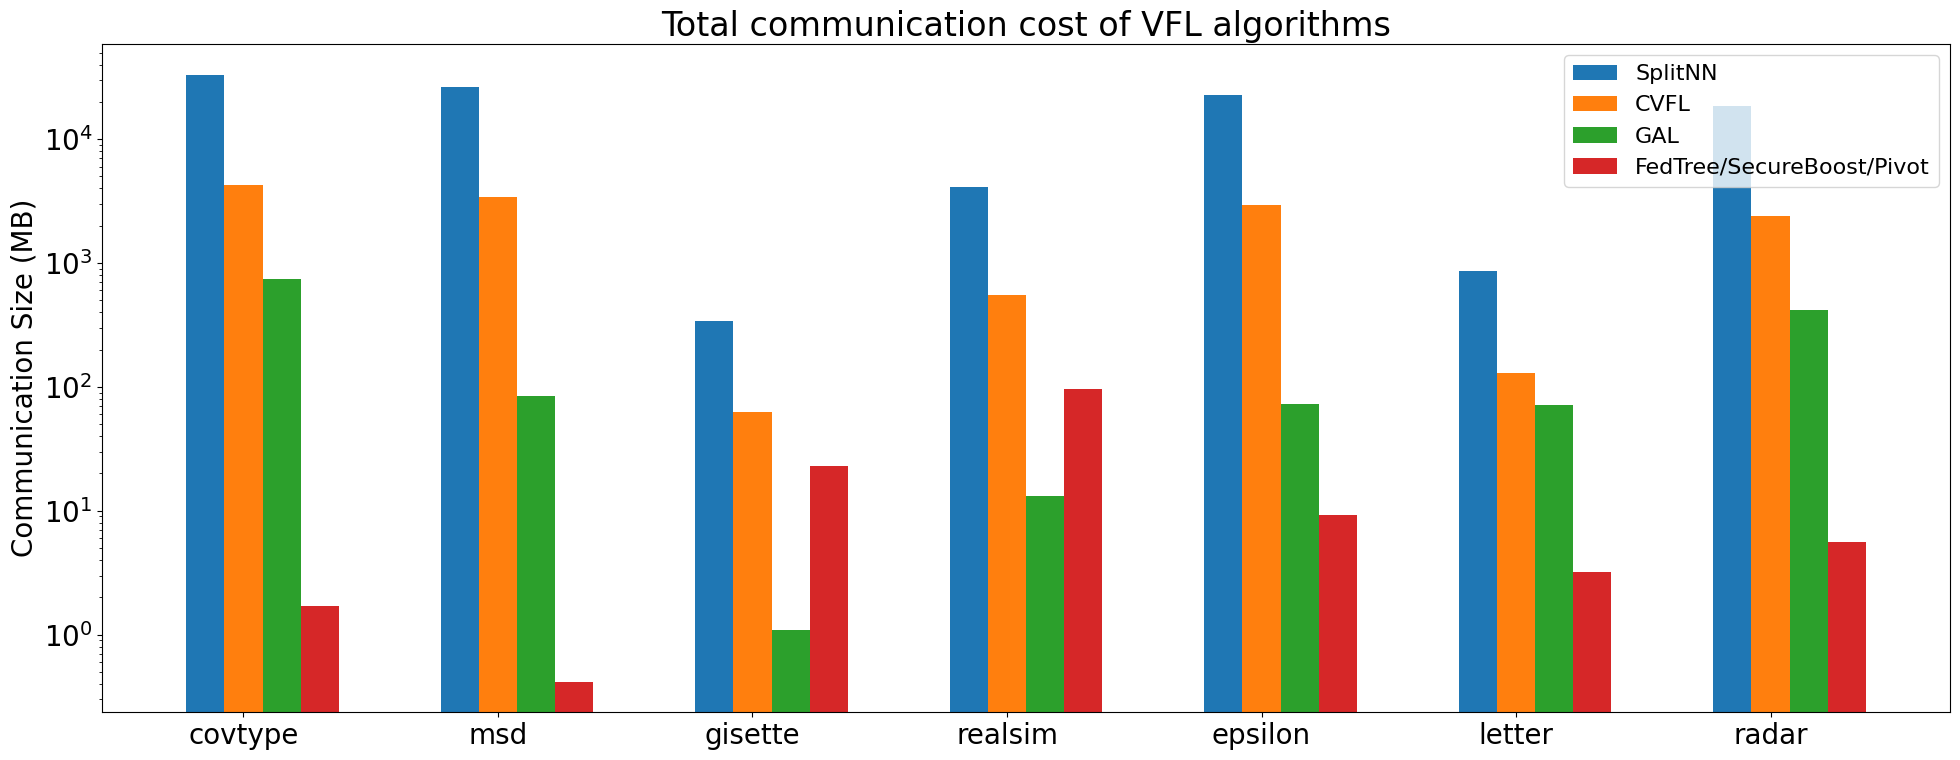

In [19]:
# plot the communication cost of each algorithm in a bar chart
algorithm_list = ['SplitNN', 'CVFL', 'GAL', 'SecureBoost']

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(20, 8))
x = np.arange(len(dataset_list))  # the label locations
width = 0.15  # the width of the bars

rects1 = ax.bar(x - width, splitnn_comm_max_in_list, width, label='SplitNN')
rects2 = ax.bar(x, cvfl_comm_max_in_list, width, label='CVFL')
rects3 = ax.bar(x + width, gal_comm_max_in_list, width, label='GAL')
rects4 = ax.bar(x + 2 * width, secureboost_comm_max_in_list, width, label='FedTree/SecureBoost/Pivot')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Communication Size (MB)')
ax.set_title('Total communication cost of VFL algorithms')
ax.set_xticks(x)
ax.set_xticklabels(dataset_list)
ax.legend(fontsize=16)
ax.set_yscale('log')

fig.tight_layout()
fig.savefig('fig/comm_total.png')
plt.show()



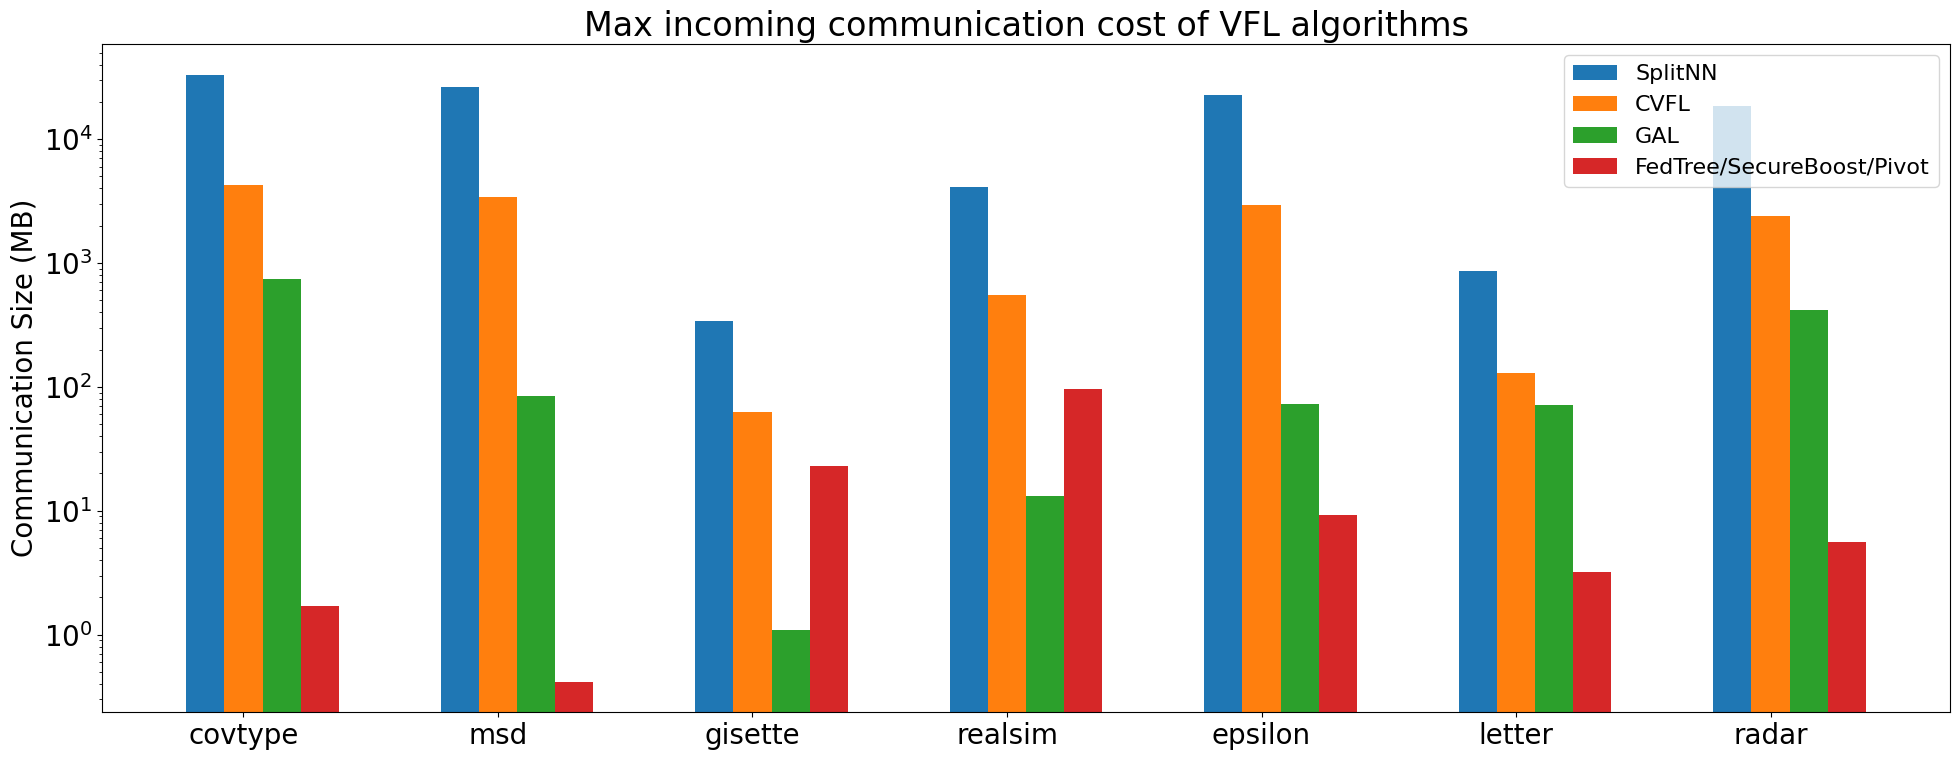

In [20]:
# plot the communication cost of each algorithm in a bar chart
algorithm_list = ['SplitNN', 'CVFL', 'GAL', 'SecureBoost']

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(20, 8))
x = np.arange(len(dataset_list))  # the label locations
width = 0.15  # the width of the bars

rects1 = ax.bar(x - width, splitnn_comm_max_in_list, width, label='SplitNN')
rects2 = ax.bar(x, cvfl_comm_max_in_list, width, label='CVFL')
rects3 = ax.bar(x + width, gal_comm_max_in_list, width, label='GAL')
rects4 = ax.bar(x + 2 * width, secureboost_comm_max_in_list, width, label='FedTree/SecureBoost/Pivot')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Communication Size (MB)')
ax.set_title('Max incoming communication cost of VFL algorithms')
ax.set_xticks(x)
ax.set_xticklabels(dataset_list)
ax.legend(fontsize=16)
ax.set_yscale('log')

fig.tight_layout()
fig.savefig('fig/comm_max_in.png')
plt.show()

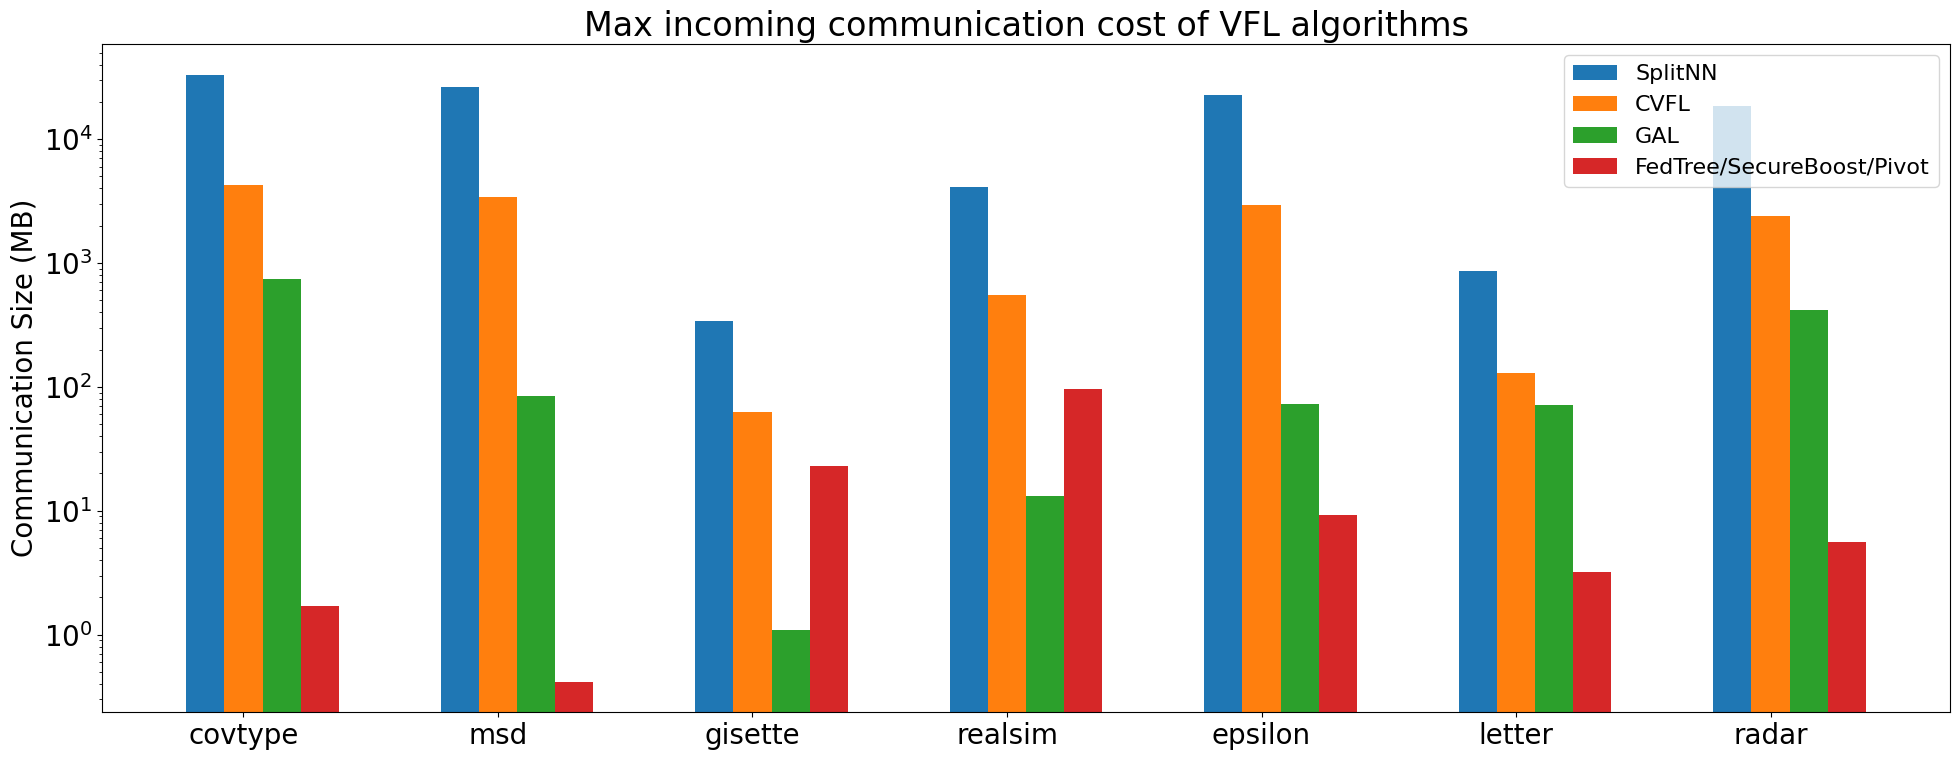

In [21]:
# plot the communication cost of each algorithm in a bar chart
algorithm_list = ['SplitNN', 'CVFL', 'GAL', 'SecureBoost']

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(20, 8))
x = np.arange(len(dataset_list))  # the label locations
width = 0.15  # the width of the bars

rects1 = ax.bar(x - width, splitnn_comm_max_in_list, width, label='SplitNN')
rects2 = ax.bar(x, cvfl_comm_max_in_list, width, label='CVFL')
rects3 = ax.bar(x + width, gal_comm_max_in_list, width, label='GAL')
rects4 = ax.bar(x + 2 * width, secureboost_comm_max_in_list, width, label='FedTree/SecureBoost/Pivot')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Communication Size (MB)')
ax.set_title('Max incoming communication cost of VFL algorithms')
ax.set_xticks(x)
ax.set_xticklabels(dataset_list)
ax.legend(fontsize=16)
ax.set_yscale('log')

fig.tight_layout()
fig.savefig('fig/comm_max_out.png')
plt.show()